# Testing for CNN Model

This notebook is used for testing a model which has been generated

In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import tensorflow as tf
from sklearn.metrics import precision_recall_curve, precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt
import config as conf
import os
import shutil
import re

All the needed variables are declared, this includes the model and any directories that will be needed

In [ ]:
# Load the trained model
model = tf.keras.models.load_model("../models/64ST.h5")

# Directory containing images to classify
source_directory = "../data/images/64_synth_true_split/test"

# Directory to save classified images
output_directory = "../128SR_WANG_M33_predictions"

# Path to the image file
image_path = "./data/rootness_cutouts/cutout_m105_g_ccd_6_10.521051_34.696718.png"

Image pre-processing used by many of the tests

In [5]:
def load_and_preprocess_image(image_path, target_size=(128, 128)):
    """Loads and preprocesses an image."""
    img = load_img(image_path, target_size=target_size, color_mode='grayscale')
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

### Predicting a single image

Takes an image path, preprocesses the image, and predicts the class.

In [4]:
# Load and preprocess the image
img_array = load_and_preprocess_image(image_path, target_size=(conf.IMAGE_SIZE, conf.IMAGE_SIZE))

# Make predictions
predictions = model.predict(img_array)

# Get the predicted class
predicted_class = np.argmax(predictions, axis=1)
predicted_prob = np.max(predictions)

print(predicted_class[0], predicted_prob)

NameError: name 'load_and_preprocess_image' is not defined

### Predict whole directory of images

Predicts classes for all images in the specified directory

In [ ]:
results = []

# Iterate over each subdirectory in the test directory
for class_folder in os.listdir(source_directory):
    class_folder_path = os.path.join(source_directory, class_folder)

    # Check if it is a directory
    if os.path.isdir(class_folder_path):
        # Iterate over each file in the class folder
        for filename in os.listdir(class_folder_path):
            # Construct full file path
            file_path = os.path.join(class_folder_path, filename)

            # Check if the file is an image
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                # Load and preprocess the image
                img_array = load_and_preprocess_image(file_path)

                # Make predictions
                predictions = model.predict(img_array)
                predicted_class = np.argmax(predictions, axis=1)[0]  # Get predicted class index
                predicted_prob = np.max(predictions)  # Get the maximum probability

                # Store the result with the actual label based on the folder name
                results.append({
                    'filename': filename,
                    'actual_class': class_folder,  # The folder name represents the actual class
                    'predicted_class': predicted_class,
                    'probability': predicted_prob
                })

print(results)

### Evaluate Model

Evaluates the model on the test dataset and plots accuracy, loss, precision, recall, and F1-score.

Found 9077 images belonging to 2 classes.


C:\Users\Squid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


182/182 ━━━━━━━━━━━━━━━━━━━━ 18s 98ms/step - accuracy: 0.9717 - loss: 0.0683
Test Loss: 0.09600930660963058
Test Accuracy: 0.9604495167732239
182/182 ━━━━━━━━━━━━━━━━━━━━ 18s 97ms/step
Class: cluster
Precision: 0.9746543778801844
Recall: 0.9444072337575352
F1-score: 0.9592924367842159

Class: non-cluster
Precision: 0.94743508549715
Recall: 0.9760765550239234
F1-score: 0.9615425816818425



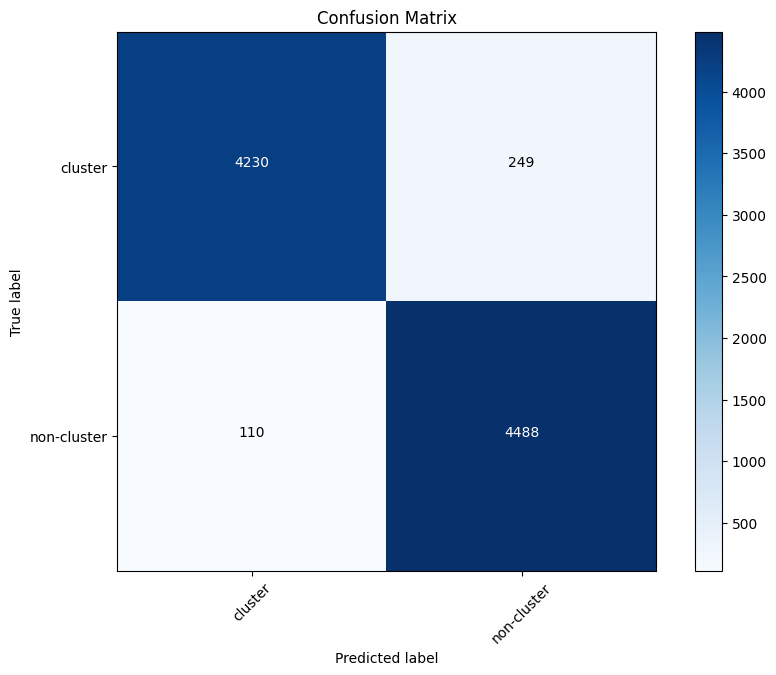

In [6]:
# Load test data
test_datagen = ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_directory(
    source_directory,
    target_size=(conf.IMAGE_SIZE, conf.IMAGE_SIZE),
    color_mode='grayscale',
    batch_size=conf.BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Evaluate the model
scores = model.evaluate(test_data)
print(f"Test Loss: {scores[0]}")
print(f"Test Accuracy: {scores[1]}")

# Predict the classes
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_data.classes

# Calculate precision, recall, and F1-score manually
precision = np.zeros(len(test_data.class_indices))
recall = np.zeros(len(test_data.class_indices))
f1_score = np.zeros(len(test_data.class_indices))

for i in range(len(test_data.class_indices)):
    true_positives = np.sum((y_true == i) & (y_pred_classes == i))
    false_positives = np.sum((y_true != i) & (y_pred_classes == i))
    false_negatives = np.sum((y_true == i) & (y_pred_classes != i))

    precision[i] = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall[i] = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i]) if (precision[i] + recall[i]) > 0 else 0

# Print precision, recall, and F1-score
for i, class_name in enumerate(test_data.class_indices.keys()):
    print(f"Class: {class_name}")
    print(f"Precision: {precision[i]}")
    print(f"Recall: {recall[i]}")
    print(f"F1-score: {f1_score[i]}")
    print()

# Plot confusion matrix
conf_matrix = np.zeros((len(test_data.class_indices), len(test_data.class_indices)), dtype=int)
for true, pred in zip(y_true, y_pred_classes):
    conf_matrix[true, pred] += 1

plt.figure(figsize=(10, 7))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(test_data.class_indices))
plt.xticks(tick_marks, test_data.class_indices.keys(), rotation=45)
plt.yticks(tick_marks, test_data.class_indices.keys())

for i in range(len(test_data.class_indices)):
    for j in range(len(test_data.class_indices)):
        plt.text(j, i, conf_matrix[i, j], horizontalalignment="center", color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### Classify and Organise Images

Classifies images in the source directory and organizes them into 'cluster' and 'non-cluster' folders.

In [8]:
# Create output directories if they don't exist
cluster_dir = os.path.join(output_directory, 'cluster')
non_cluster_dir = os.path.join(output_directory, 'non-cluster')
os.makedirs(cluster_dir, exist_ok=True)
os.makedirs(non_cluster_dir, exist_ok=True)

# Iterate over each file in the source directory
for filename in os.listdir(source_directory):
    file_path = os.path.join(source_directory, filename)

    # Check if the file is an image
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
        # Load and preprocess the image
        img_array = load_and_preprocess_image(file_path, target_size=(conf.IMAGE_SIZE, conf.IMAGE_SIZE))

        # Make predictions
        predictions = model.predict(img_array)
        predicted_class = np.argmax(predictions, axis=1)[0]  # Get predicted class index

        # Determine the target directory based on the predicted class
        target_dir = cluster_dir if predicted_class == 0 else non_cluster_dir

        # Copy the image to the target directory
        shutil.copy(file_path, target_dir)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━

### Predict and Plot Images

Makes predictions on the test dataset and plots RA and DEC coordinates.

In [ ]:
# Lists to store RA and DEC values for plotting
ra_correct = []
dec_correct = []
ra_incorrect = []
dec_incorrect = []

# Function to extract RA and DEC from filename
def extract_ra_dec(filename):
    match = re.search(r'_(\d+\.\d+)_(\d+\.\d+)\.png$', filename)
    if match:
        ra = float(match.group(1))
        dec = float(match.group(2))
        # One of the RAs is far out, added to
        if ra < 40:
            return ra, dec
    return None, None

# Iterate over each subdirectory in the test directory
for class_folder in os.listdir(source_directory):
    class_folder_path = os.path.join(source_directory, class_folder)

    # Check if it is a directory
    if os.path.isdir(class_folder_path):
        # Iterate over each file in the class folder
        for filename in os.listdir(class_folder_path):
            # Construct full file path
            file_path = os.path.join(class_folder_path, filename)

            # Check if the file is an image
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                # Load and preprocess the image
                img_array = load_and_preprocess_image(file_path, target_size=(conf.IMAGE_SIZE, conf.IMAGE_SIZE))

                # Make predictions
                predictions = model.predict(img_array)
                predicted_class = np.argmax(predictions, axis=1)[0]  # Get predicted class index

                # Extract RA and DEC from the filename
                ra, dec = extract_ra_dec(filename)

                # Check if the prediction is correct
                actual_class = 0 if class_folder == 'cluster' else 1
                if predicted_class == actual_class:
                    ra_correct.append(ra)
                    dec_correct.append(dec)
                else:
                    ra_incorrect.append(ra)
                    dec_incorrect.append(dec)

# Create a scatter plot
plt.figure(figsize=(10, 6))

# Plot correct and incorrect points with different colors
plt.scatter(ra_correct, dec_correct, color='green', label='Correct', alpha=0.6)
plt.scatter(ra_incorrect, dec_incorrect, color='red', label='Incorrect', alpha=0.6)

# Add labels and title
plt.xlabel('RA (degrees)')
plt.ylabel('DEC (degrees)')
plt.title('RA and DEC Coordinates by Prediction Accuracy')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

### Evaluate a Models Precision and Recall

Evaluates the model on the test dataset and plots the precision-recall curve.

In [5]:
def calculate_metrics(y_true, y_pred_probs, thresholds):
    precisions = []
    recalls = []
    for threshold in thresholds:
        y_pred = (y_pred_probs >= threshold).astype(int)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        precisions.append(precision)
        recalls.append(recall)
    return precisions, recalls

In [7]:
def plot_precision_recall_curve(y_true, y_pred_probs):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_probs)
    plt.figure(figsize=(10, 6))
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.grid(True)
    plt.show()

In [ ]:
# Load test data
test_datagen = ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_directory(
    source_directory,
    target_size=(conf.IMAGE_SIZE, conf.IMAGE_SIZE),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Get true labels and predicted probabilities
y_true = test_data.classes
y_pred_probs = model.predict(test_data)[:, 1]

# Tweakable thresholds
thresholds = np.arange(0.0, 1.1, 0.1)

# Calculate precision and recall for different thresholds
precisions, recalls = calculate_metrics(y_true, y_pred_probs, thresholds)

# Plot precision-recall curve
plot_precision_recall_curve(y_true, y_pred_probs)

# Print precision and recall for different thresholds
for threshold, precision, recall in zip(thresholds, precisions, recalls):
    print(f"Threshold: {threshold:.1f}, Precision: {precision:.2f}, Recall: {recall:.2f}")

### Classify and Organise based on Correctness

Classifies images in the source directory and organizes them into 'correct' and 'incorrect' folders.

In [ ]:
# Create output directories if they don't exist
correct_dir = os.path.join(output_directory, 'correct')
incorrect_dir = os.path.join(output_directory, 'incorrect')
os.makedirs(correct_dir, exist_ok=True)
os.makedirs(incorrect_dir, exist_ok=True)

# Iterate over each file in the source directory
for filename in os.listdir(source_directory):
    file_path = os.path.join(source_directory, filename)

    # Check if the file is an image
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
        # Load and preprocess the image
        img_array = load_and_preprocess_image(file_path, target_size=(conf.IMAGE_SIZE, conf.IMAGE_SIZE))

        # Make predictions
        predictions = model.predict(img_array)
        predicted_class = np.argmax(predictions, axis=1)[0]

        # Since all images are of type "cluster", the actual class is 0
        actual_class = 1

        # Determine the target directory based on the prediction accuracy
        target_dir = correct_dir if predicted_class == actual_class else incorrect_dir

        # Copy the image to the target directory
        shutil.copy(file_path, os.path.join(target_dir, filename))

print("Images have been classified and organized into 'correct' and 'incorrect' folders.")